# Markov chains with `striplog`

Launch this notebook:

https://colab.research.google.com/github/agile-geoscience/striplog/blob/develop/tutorial/Markov_chains.ipynb

-----

You need `striplog` version 0.8.6 or later for this notebook to work as intended.

---

In [1]:
import striplog

striplog.__version__

'0.8.6'

## 2 ways to get a Markov chain

There are two ways to generate [a Markov chain](https://en.wikipedia.org/wiki/Markov_chain):

1. Parse one or more sequences of states. This will be turned into a transition matrix, from which a probability matrix will be computed.
1. Directly from a transition matrix, if you already have that data.

Let's look at the transition matrix first, since that's how Powers & Easterling presented the data in their paper on this topic.

----

## Powers & Easterling data

Key reference: Powers, DW and RG Easterling (1982). Improved methodology for using embedded Markov chains to describe cyclical sediments. _Journal of Sedimentary Petrology_ **52** (3), p 913&ndash;923.

Let's use one of the examples in Powers & Easterling &mdash; they use this transition matrix from Gingerich, PD (1969). Markov analysis of cyclic alluvial sediments. _Journal of Sedimentary Petrology_, 39, p. 330-332. https://doi.org/10.1306/74D71C4E-2B21-11D7-8648000102C1865D

In [2]:
from striplog.markov import Markov_chain

In [3]:
data = [[ 0, 37,  3,  2],
        [21,  0, 41, 14],
        [20, 25,  0,  0],
        [ 1, 14,  1,  0]]

m = Markov_chain(data, states=['A', 'B', 'C', 'D'])

m

Markov_chain(179 transitions, states=['A', 'B', 'C', 'D'], step=1, include_self=False)

Note that they do not include self-transitions in their data. So the elements being counted are simple 'beds' not 'depth samples' (say).

If you build a Markov chain using a matrix with self-transitions, these will be preserved; note `include_self=True` in the example here:

In [4]:
data = [[10, 37,  3,  2],
        [21, 20, 41, 14],
        [20, 25, 20,  0],
        [ 1, 14,  1, 10]]

Markov_chain(data)

Markov_chain(239 transitions, states=[0, 1, 2, 3], step=1, include_self=True)

### Testing for independence

We use the model of quasi-independence given in Powers & Easterling, as opposed to an independent model like `scipy.stats.chi2_contingency()`, for computing chi-squared and the expected transitions:

First, let's look at the expected transition frequencies of the original Powers & Easterling data:

In [5]:
import numpy as np

np.set_printoptions(precision=3)

In [6]:
m.expected_counts

array([[ 0.   , 31.271,  8.171,  2.558],
       [31.282,  0.   , 34.057, 10.661],
       [ 8.171, 34.044,  0.   ,  2.785],
       [ 2.558, 10.657,  2.785,  0.   ]])

The $\chi^2$ statistic shows the value for the observed ordering, along with the critical value at (by default) the 95% confidence level. If the first number is higher than the second number (ideally much higher), then we can reject the hypothesis that the ordering is quasi-independent. That is, we have shown that the ordering is non-random.

In [7]:
m.chi_squared()

Chi2(chi2=35.73687369691601, crit=11.070497693516351, perc=0.9999989278539752)

### Which transitions are interesting?

The normalized difference shows which transitions are 'interesting'. These numbers can be interpreted as standard deviations away from the model of quasi-independence. That is, transitions with large positive numbers represent passages that occur more often than might be expected. Any numbers greater than 2 are likely to be important.

In [8]:
m.normalized_difference

array([[ 0.   ,  1.025, -1.809, -0.349],
       [-1.838,  0.   ,  1.19 ,  1.023],
       [ 4.138, -1.55 ,  0.   , -1.669],
       [-0.974,  1.024, -1.07 ,  0.   ]])

We can visualize this as an image:

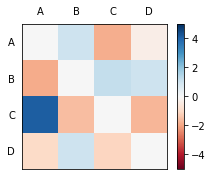

In [9]:
m.plot_norm_diff()

We can also interpret this matrix as a graph. The upward transitions from C to A are particularly strong in this one. Transitions from A to C happen less often than we'd expect. Those from B to D and D to B, less so.

It's arguably easier to interpret the data when this matrix is interpreted as [a directed graph](https://en.wikipedia.org/wiki/Directed_graph):

/home/matt/anaconda3/envs/welly/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/matt/anaconda3/envs/welly/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


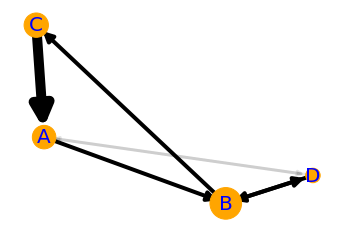

In [10]:
m.plot_graph()

We can look at an undirected version of the graph too. It downplays non-reciprocal relationships. I'm not sure this is useful...

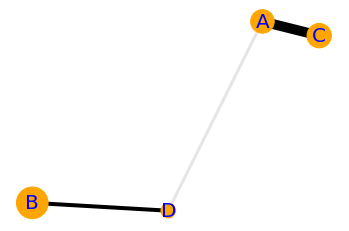

In [11]:
m.plot_graph(directed=False)

## Generating random sequences

We can generate a random succession of beds with the same transition statistics:

In [12]:
''.join(m.generate_states(n=30))

'ABCBCBCABCBABCABABABABCABACBDB'

Again, this will respect the absence or presence of self-transitions, e.g.:

In [13]:
data = [[10, 37,  3,  2],
        [21, 20, 41, 14],
        [20, 25, 20,  0],
        [ 1, 14,  1, 10]]

x = Markov_chain(data)

''.join(map(str, x.generate_states(n=30)))

'020003310020133201020131201201'

----

## Parse states

Striplog can interpret various kinds of data as **sequences** of **states**. For example, it can get the unique elements and a 'sequence of sequences' from:

- A simple list of states, eg `[1,2,2,2,1,1]`
- A string of states, eg `'ABBDDDDDCCCC'`
- A list of lists of states, eg `[[1,2,2,3], [2,4,2]]`  (NB, not same length)
- A list of strings of states, eg `['aaabb', 'aabbccc']` (NB, not same length)
- A list of state names, eg `['sst', 'mud', 'sst']` (requires optional argument)
- A list of lists of state names, eg `[['SS', 'M', 'SS'], ['M', 'M', 'LS']]`

The corresponding sets of unique states look like:

- `[1, 2]`
- `['A', 'B', 'C', 'D']`
- `[1, 2, 3, 4]`
- `['a', 'b', 'c']`
- `['mud', sst']`
- `['LS', 'M', 'SS']`

Let's look at a data example...


## Data from Matt's thesis

These are the transitions from some measured sections in my PhD thesis. They start at the bottom, so in Log 7, we start with lithofacies 1 (offshore mudstone) and pass upwards into lithofacies 3, then back into 1, then 3, and so on.

We can instantiate a `Markov_chain` object from a sequence using its `from_sequence()` method. This expects either a sequence of 'states' (numbers or letters or strings representing rock types) or a sequence of sequences of states.

In [14]:
data = {
    'log7':  [1, 3, 1, 3, 5, 1, 2, 1, 3, 1, 5, 6, 1, 2, 1, 2, 1, 2, 1, 3, 5, 6, 5, 1],
    'log9':  [1, 3, 1, 5, 1, 5, 3, 1, 2, 1, 2, 1, 3, 5, 1, 5, 6, 5, 6, 1, 2, 1, 5, 6, 1],
    'log11': [1, 3, 1, 2, 1, 5, 3, 1, 2, 1, 2, 1, 3, 5, 3, 5, 1, 9, 5, 5, 5, 5, 6, 1],
    'log12': [1, 5, 3, 1, 2, 1, 2, 1, 2, 1, 4, 5, 6, 1, 2, 1, 4, 5, 1, 5, 5, 5, 1, 2, 1, 8, 9, 10, 9, 5, 1],
    'log13': [1, 6, 1, 3, 1, 3, 5, 3, 6, 1, 6, 5, 3, 1, 5, 1, 2, 1, 4, 3, 5, 3, 4, 3, 5, 1, 5, 9, 11, 9, 1],
    'log14': [1, 3, 1, 5, 8, 5, 6, 1, 3, 4, 5, 3, 1, 3, 5, 1, 7, 7, 7, 1, 7, 1, 3, 8, 5, 5, 1, 5, 9, 9, 11, 9, 1],
    'log15': [1, 8, 1, 3, 5, 1, 2, 3, 6, 3, 6, 5, 2, 1, 2, 1, 8, 5, 1, 5, 9, 9, 11, 1],
    'log16': [1, 8, 1, 5, 1, 5, 5, 6, 1, 3, 5, 3, 5, 5, 5, 8, 5, 1, 9, 9, 3, 1],
    'log17': [1, 3, 8, 1, 8, 5, 1, 8, 9, 5, 10, 5, 8, 9, 10, 8, 5, 1, 8, 9, 1],
    'log18': [1, 8, 2, 1, 2, 1, 10, 8, 9, 5, 5, 1, 2, 1, 2, 9, 5, 9, 5, 8, 5, 9, 1]
}

logs = list(data.values())

m = Markov_chain.from_sequence(logs)
m.states

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [15]:
m.observed_counts

array([[ 0, 21, 17,  3, 15,  2,  2,  8,  2,  1,  0],
       [21,  0,  1,  0,  0,  0,  0,  0,  1,  0,  0],
       [12,  0,  0,  2, 12,  3,  0,  2,  0,  0,  0],
       [ 0,  0,  2,  0,  3,  0,  0,  0,  0,  0,  0],
       [19,  1,  9,  0,  0,  9,  0,  4,  5,  1,  0],
       [ 9,  0,  1,  0,  4,  0,  0,  0,  0,  0,  0],
       [ 2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 3,  1,  0,  0,  7,  0,  0,  0,  5,  0,  0],
       [ 4,  0,  1,  0,  6,  0,  0,  0,  0,  2,  3],
       [ 0,  0,  0,  0,  1,  0,  0,  2,  1,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0]])

Let's check out the normalized difference matrix:

In [16]:
m.expected_counts

array([[0.000e+00, 9.734e+00, 1.362e+01, 1.972e+00, 2.329e+01, 5.709e+00,
        7.807e-01, 6.576e+00, 6.576e+00, 1.572e+00, 1.175e+00],
       [9.734e+00, 0.000e+00, 2.949e+00, 4.270e-01, 5.042e+00, 1.236e+00,
        1.690e-01, 1.424e+00, 1.424e+00, 3.404e-01, 2.544e-01],
       [1.362e+01, 2.949e+00, 0.000e+00, 5.974e-01, 7.054e+00, 1.729e+00,
        2.365e-01, 1.992e+00, 1.992e+00, 4.762e-01, 3.559e-01],
       [1.972e+00, 4.270e-01, 5.974e-01, 0.000e+00, 1.022e+00, 2.504e-01,
        3.425e-02, 2.885e-01, 2.885e-01, 6.896e-02, 5.154e-02],
       [2.329e+01, 5.042e+00, 7.054e+00, 1.021e+00, 0.000e+00, 2.957e+00,
        4.044e-01, 3.406e+00, 3.406e+00, 8.143e-01, 6.086e-01],
       [5.709e+00, 1.236e+00, 1.729e+00, 2.504e-01, 2.957e+00, 0.000e+00,
        9.914e-02, 8.351e-01, 8.351e-01, 1.996e-01, 1.492e-01],
       [7.806e-01, 1.690e-01, 2.365e-01, 3.425e-02, 4.044e-01, 9.914e-02,
        0.000e+00, 1.142e-01, 1.142e-01, 2.730e-02, 2.040e-02],
       [6.576e+00, 1.424e+00, 1.99

It's hard to read this but we can change NumPy's display options:

In [17]:
np.set_printoptions(suppress=True, precision=1, linewidth=120)
m.normalized_difference

array([[ 0. ,  3.6,  0.9,  0.7, -1.7, -1.6,  1.4,  0.6, -1.8, -0.5, -1.1],
       [ 3.6,  0. , -1.1, -0.7, -2.2, -1.1, -0.4, -1.2, -0.4, -0.6, -0.5],
       [-0.4, -1.7,  0. ,  1.8,  1.9,  1. , -0.5,  0. , -1.4, -0.7, -0.6],
       [-1.4, -0.7,  1.8,  0. ,  2. , -0.5, -0.2, -0.5, -0.5, -0.3, -0.2],
       [-0.9, -1.8,  0.7, -1. ,  0. ,  3.5, -0.6,  0.3,  0.9,  0.2, -0.8],
       [ 1.4, -1.1, -0.6, -0.5,  0.6,  0. , -0.3, -0.9, -0.9, -0.4, -0.4],
       [ 1.4, -0.4, -0.5, -0.2, -0.6, -0.3,  0. , -0.3, -0.3, -0.2, -0.1],
       [-1.4, -0.4, -1.4, -0.5,  1.9, -0.9, -0.3,  0. ,  4.1, -0.5, -0.4],
       [-1. , -1.2, -0.7, -0.5,  1.4, -0.9, -0.3, -1. ,  0. ,  3.7,  6.8],
       [-1.3, -0.6, -0.7, -0.3,  0.2, -0.4, -0.2,  3.7,  1.6,  0. , -0.2],
       [-0.2, -0.5, -0.6, -0.2, -0.8, -0.4, -0.1, -0.4,  4.4, -0.2,  0. ]])

Or use a graphical view:

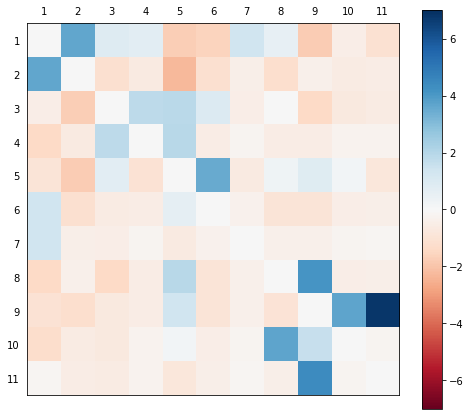

In [18]:
m.plot_norm_diff()

And the graph version. **Note you can re-run this cell to rearrange the graph.**

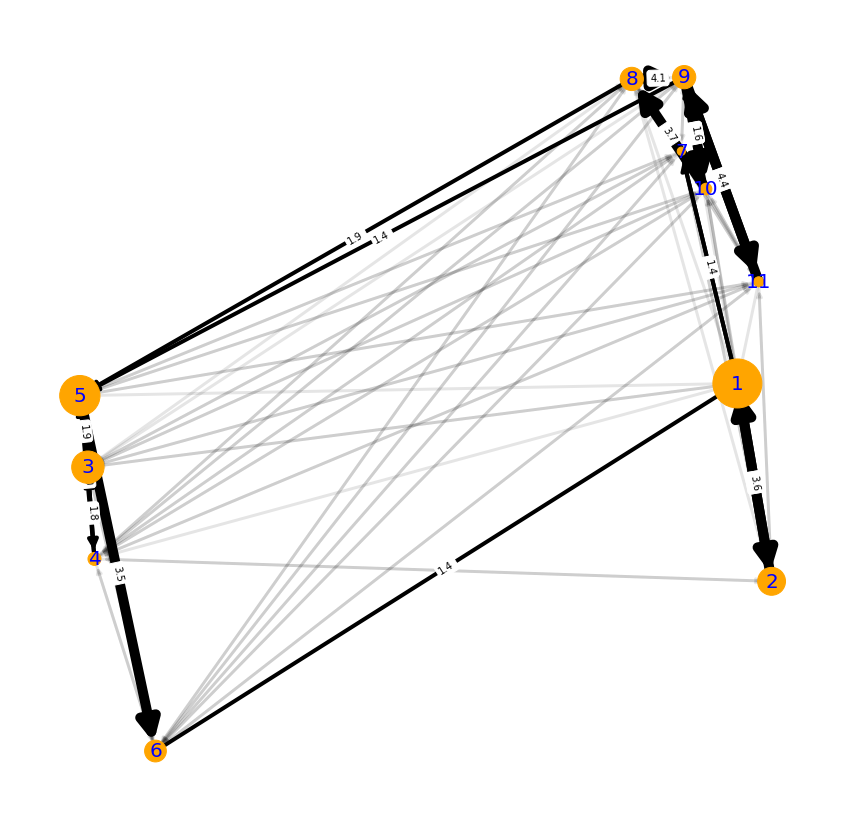

In [19]:
m.plot_graph(figsize=(15,15), max_size=2400, edge_labels=True)

<div style="border: solid red 2px; border-radius:5px; background-color:#ffeeee; padding:10px 10px 20px 10px;">
<h3>Experimental implementation!</h3>

<p>Multistep Markov chains are a bit of an experiment in `striplog`. Please [get in touch](matt@agilescientific.com) if you have thoughts about how it should work.</p>

</div>

## Step = 2

So far we've just been looking at direct this-to-that transitions, i.e. only considering each previous transition. What if we use the previous-but-one?

In [22]:
m = Markov_chain.from_sequence(logs, step=2)
m

Markov_chain(213 transitions, states=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], step=2, include_self=False)

Note that self-transitions are ignored by default. With multi-step transitions, this results in a lot of zeros because we don't just eliminate transitions like 1 > 1 > 1, but also 1 > 1 > 2 and 1 > 1 > 3, etc, *as well as* 1 > 2 > 2, 1 > 3 > 3, etc, *and* 2 > 1 > 1, 3 > 1 > 1, etc. (But we will keep 1 > 2 > 1.) 

Now we have a 3D array of transition probabilities.

In [23]:
m.normalized_difference.shape

(11, 11, 11)

This is hard to inspect! Let's just get the indices of the highest values.

If we add one to the indices, we'll have a handy list of facies number transitions, since these are just 1 to 11. So we can interpret these as transitions with anomalously high probability. 

<img src="Normal_distribution.png" />

There are 11 &times; 11 &times; 11 = 1331 transitions in this array (inluding self-transitions).

In [26]:
cutoff = 5  # 1.96 is 95% confidence

idx = np.where(m.normalized_difference > cutoff)
locs = np.array(list(zip(*idx)))

scores = {tuple(loc+1):score for score, loc in zip(m.normalized_difference[idx], locs)}
    
for (a, b, c), score in sorted(scores.items(), key=lambda pair: pair[1], reverse=True):
    print(f"{a:<2} -> {b:<2} -> {c:<2}   {score:.3f}")

8  -> 9  -> 10   16.027
9  -> 11 -> 9    14.608
1  -> 2  -> 1    10.021
7  -> 1  -> 7    8.918
9  -> 10 -> 8    8.918
9  -> 10 -> 9    8.918
2  -> 1  -> 2    8.406
11 -> 9  -> 1    7.627
10 -> 8  -> 9    6.227
2  -> 1  -> 4    5.645
5  -> 6  -> 1    5.316


In [27]:
m.chi_squared()

Chi2(chi2=1463.1638736696714, crit=112.02198574980785, perc=1.0)

Unfortunately, it's a bit harder to draw this as a graph. Technically, it's a [**hypergraph**](https://en.wikipedia.org/wiki/Hypergraph).

In [28]:
# This should error for now.
m.plot_graph(figsize=(15,15), max_size=2400, edge_labels=True)

MarkovError: You can only graph one-step chains.

Also, the expected counts or frequencies are a bit... hard to interpret:

In [29]:
np.set_printoptions(suppress=True, precision=3, linewidth=120)

m.expected_counts

array([[[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [2.659, 0.   , 1.239, ..., 0.564, 0.153, 0.15 ],
        [3.637, 1.221, 0.   , ..., 0.794, 0.239, 0.135],
        ...,
        [1.76 , 0.592, 0.868, ..., 0.   , 0.092, 0.092],
        [0.466, 0.163, 0.248, ..., 0.123, 0.   , 0.015],
        [0.353, 0.144, 0.144, ..., 0.067, 0.009, 0.   ]],

       [[0.   , 0.923, 1.264, ..., 0.607, 0.12 , 0.104],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [1.279, 0.423, 0.   , ..., 0.334, 0.086, 0.064],
        ...,
        [0.662, 0.202, 0.261, ..., 0.   , 0.025, 0.012],
        [0.138, 0.049, 0.077, ..., 0.018, 0.   , 0.003],
        [0.15 , 0.064, 0.055, ..., 0.015, 0.012, 0.   ]],

       [[0.   , 1.328, 1.546, ..., 0.825, 0.202, 0.15 ],
        [1.187, 0.   , 0.616, ..., 0.273, 0.058, 0.049],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        ...,
        [0.914, 0.285, 0.417, ..., 0.   , 0.046, 0.021],
        [0.233, 0.089, 0.107, ..., 0.083, 0. 

## Step = 3

We can actually make a model for any number of steps, but we will need commensurately more data, especially if we're not going to include self-transitions:

In [30]:
m = Markov_chain.from_sequence(logs, step=3)
m

Markov_chain(193 transitions, states=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], step=3, include_self=False)

I have no idea how to visualize or interpret this thing, let me know if you do something with it!

## From `Striplog()` instance

I use `striplog` to represent stratigraphy. Let's make a Markov chain model from an instance of `striplog`!

First, we'll make a striplog by applying a couple of cut-offs to a GR log:

In [31]:
from welly import Well
from striplog import Striplog, Component

w = Well.from_las("P-129_out.LAS")
gr = w.data['GR']

comps = [Component({'lithology': 'sandstone'}),
         Component({'lithology': 'greywacke'}),
         Component({'lithology': 'shale'}),
        ]

s = Striplog.from_log(gr, cutoff=[30, 90], components=comps, basis=gr.basis)
s

Found nonstandard LAS section: ~Parameter
/home/matt/anaconda3/envs/welly/lib/python3.8/site-packages/welly/well.py:194: FutureWarning: From v0.5 the default will be 'original', keeping whatever is used in the LAS file. If you want to force conversion to metres, change your code to use `index='m'`.
  warnings.warn(m, FutureWarning)


Striplog(672 Intervals, start=1.0668, stop=1939.1376000000012)

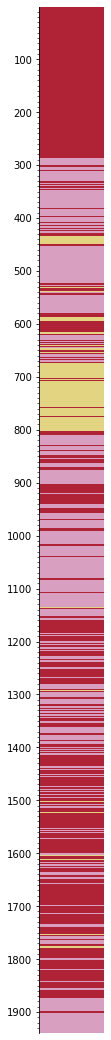

In [32]:
s.plot()

Here's what one bed (`interval` in striplog's vocabulary) looks like:

In [33]:
s[0]

Interval({'top': Position({'middle': 1.0668, 'units': 'm'}), 'base': Position({'middle': 136.85520000000008, 'units': 'm'}), 'description': '', 'data': {}, 'components': [Component({'lithology': 'greywacke'})]})

It's easy to get the 'lithology' attribute from all the beds:

In [34]:
seq = [i.primary.lithology for i in s]

This is what we need!

In [35]:
m = Markov_chain.from_sequence(seq, strings_are_states=True, include_self=False)

In [36]:
m.normalized_difference

array([[ 0.   ,  0.085,  0.023],
       [ 0.121,  0.   , -0.926],
       [-0.008, -0.928,  0.   ]])

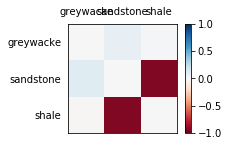

In [37]:
m.plot_norm_diff()

/home/matt/anaconda3/envs/welly/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/matt/anaconda3/envs/welly/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


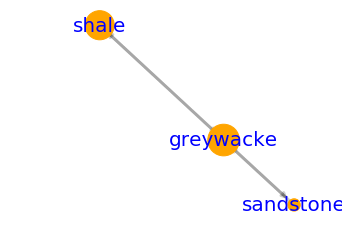

In [38]:
m.plot_graph()

----

&copy; Agile Scientific 2020, licensed CC-BY / Apache 2.0, please share this work